In [1]:
import numpy as np
import pylab as plt
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

X,y = load_mnist('./fashionmnist/')

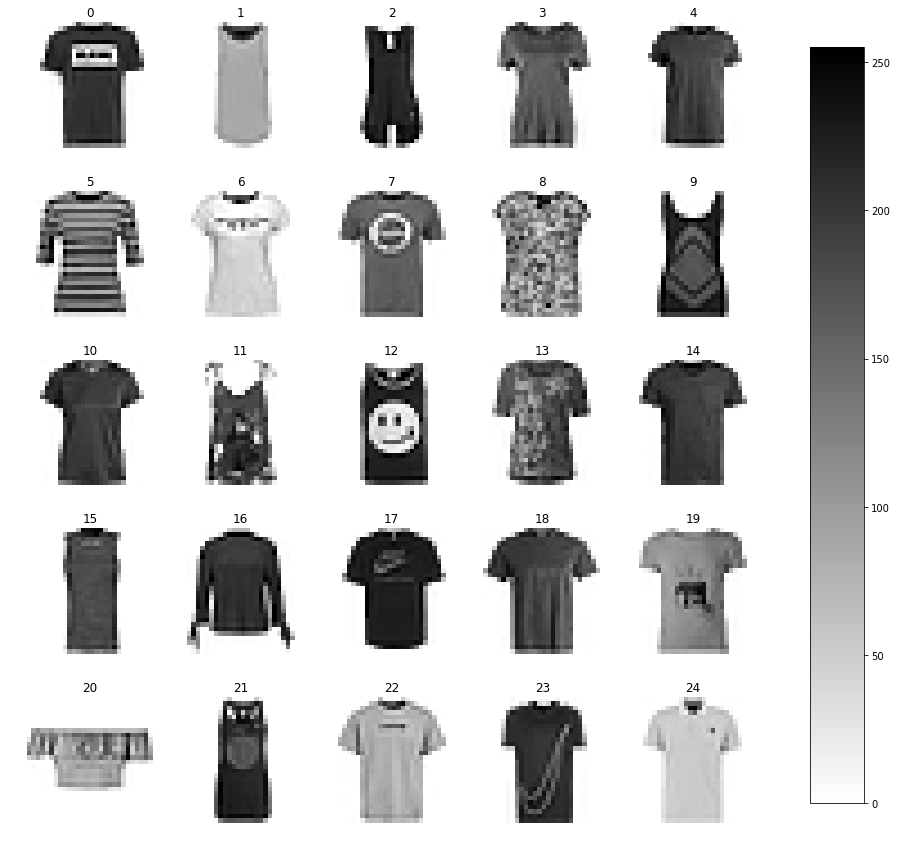

In [2]:
c = 0 # choose one of the classes 0 to 9
# suggested classes to look at : 0 tshirt, 3 dress, 7 shoe

Xc = X[y==c]
llength = int(np.sqrt(X.shape[1])) # get length of x,y for reshape

fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(25):
    im = axs[i].imshow(Xc[i].reshape(llength,llength),cmap='gray_r')
    axs[i].set_title(str(i))
    axs[i].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fname = './images/originals.png'
plt.savefig(fname,dpi=300)

In [4]:
def plot_codebook(model, individual_scaling=False, export=True):
    
    codebook = model.codebook.reshape(-1, 28, 28)
    
    fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=.5, wspace=.001)
    axs = axs.ravel()

    vmax = np.max(codebook)
    vmin = np.min(codebook)
    lim = np.max((np.abs(vmax), np.abs(vmin)))
    for i in range(25):
        if individual_scaling:
            vmax = np.max(codebook[i])
            vmin = np.min(codebook[i])
            lim = np.max((np.abs(vmax),np.abs(vmin)))
        im = axs[i].imshow(codebook[i], cmap='RdGy', vmin=-lim, vmax=lim)
        axs[i].set_title(str(i))
        axs[i].axis('off')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[-lim, 0, lim])
    cbar.ax.set_yticklabels(['-', '0', '+'],fontsize=10) 

    if export:
        fname = f'./images/{model.name()}_codebook.png'
        plt.savefig(fname,dpi=300)
        
def plot_encodings(X,model,export=True):
    
    X = Xc.reshape(-1,28,28)
    encodings = model.encodings.reshape(-1,5,5)
    reconstruction = model.reconstruction.reshape(-1,28,28)
    
    fig, axs = plt.subplots(6,3, figsize=(12,20), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    for i in range(6):
        orig = axs[i*3].imshow(X[i],cmap='gray_r')
        axs[i*3].title.set_text(f'original'); axs[i*3].axis('off')
    
        vmax = np.max(encodings[i])
        vmin = np.min(encodings[i])
        lim = np.max((np.abs(vmax),np.abs(vmin)))
        enc = axs[i*3+1].imshow(encodings[i],cmap='RdGy',vmin=-lim,vmax=lim);
        axs[i*3+1].title.set_text(f'encoding'); axs[i*3+1].axis('off')
    
        reco = axs[i*3+2].imshow(reconstruction[i],cmap='gray_r')
        axs[i*3+2].title.set_text(f'reconstruction'); axs[i*3+2].axis('off')
    
    if export:
        fname = f'./images/{model.name()}_encoding_reconstruction.png'
        plt.savefig(fname,dpi=300)

In [5]:
class PCA(PCA):
    
    def fit_extended(self,data):
        self.data = data
        self.encodings = self.fit_transform(data)
        self.codebook = self.components_
        self.reconstruction = self.inverse_transform(self.encodings)
        return self
    
    def name(self):
        return f'pca-{self.n_components_}'

pca = PCA(n_components=25, 
          svd_solver='randomized',
          whiten=True).fit_extended(Xc)

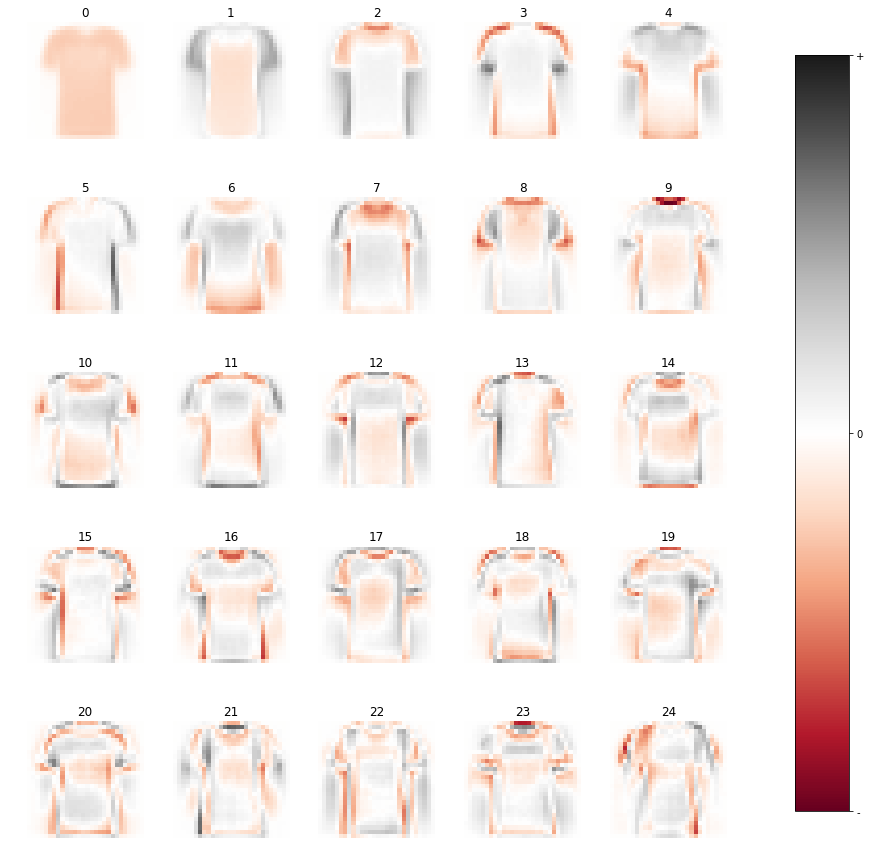

In [6]:
plot_codebook(pca)

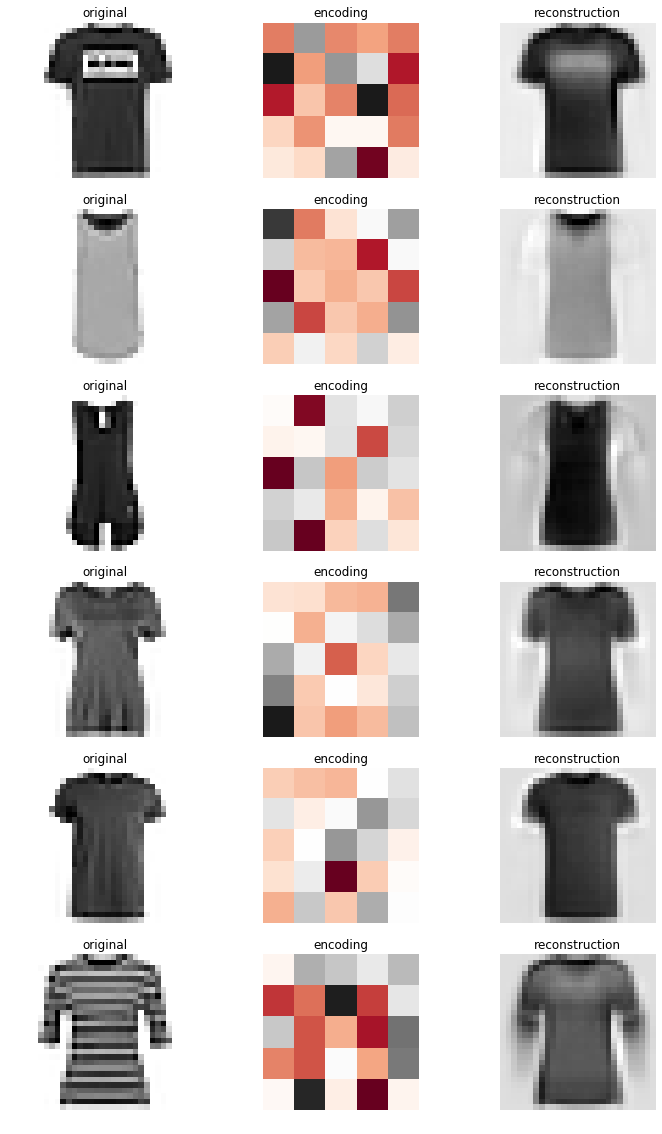

In [7]:
plot_encodings(Xc,pca)

In [8]:
class NMF(NMF):
    def fit_extended(self,data):
        self.data = data
        self.encodings = self.fit_transform(data)
        self.codebook = self.components_
        self.reconstruction = self.inverse_transform(self.encodings)
        return self
    
    def name(self):
        return f'nmf-{self.n_components_}'

nmf = NMF(n_components=25,
          init='nndsvd', 
          tol=1e-9, 
          solver='cd', 
          max_iter=200).fit_extended(Xc)

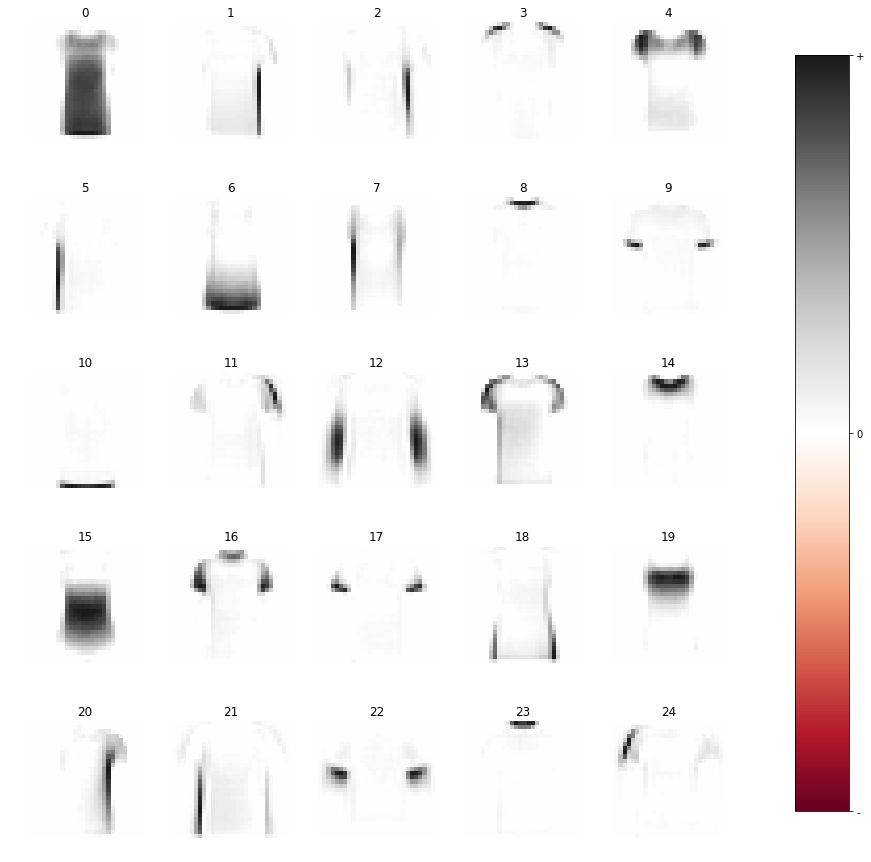

In [9]:
plot_codebook(nmf, individual_scaling=True)

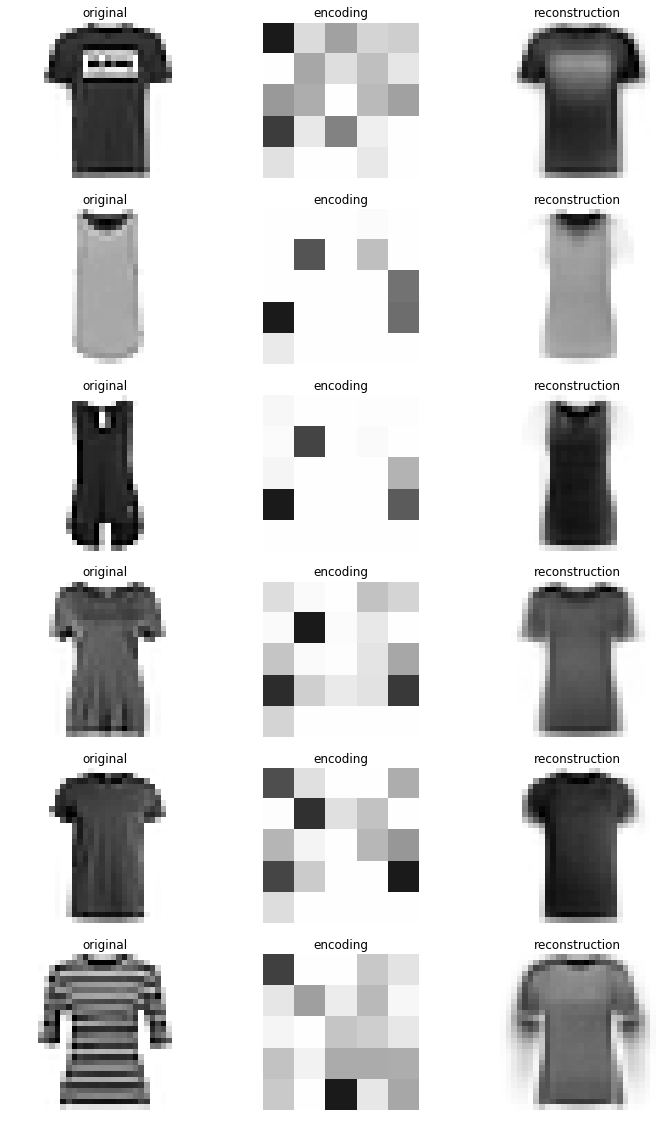

In [10]:
plot_encodings(Xc,nmf)

In [15]:
class KMeans(KMeans):
    def fit_extended(self,data):
        encodings_dummy = self.fit_predict(Xc).reshape(-1,1)

        enc = OneHotEncoder(categories='auto')
        self.encodings = enc.fit_transform(encodings_dummy).todense()
        self.codebook = self.cluster_centers_
        self.reconstruction = np.array(self.encodings @ self.codebook)
        self.encodings = (np.array(self.encodings) == 0) * 1
        return self

    def name(self):
        return f'kmeans-{self.n_clusters}'
    
kmeans = KMeans(n_clusters = 25,
                init = 'k-means++',
                n_jobs = -1).fit_extended(Xc)

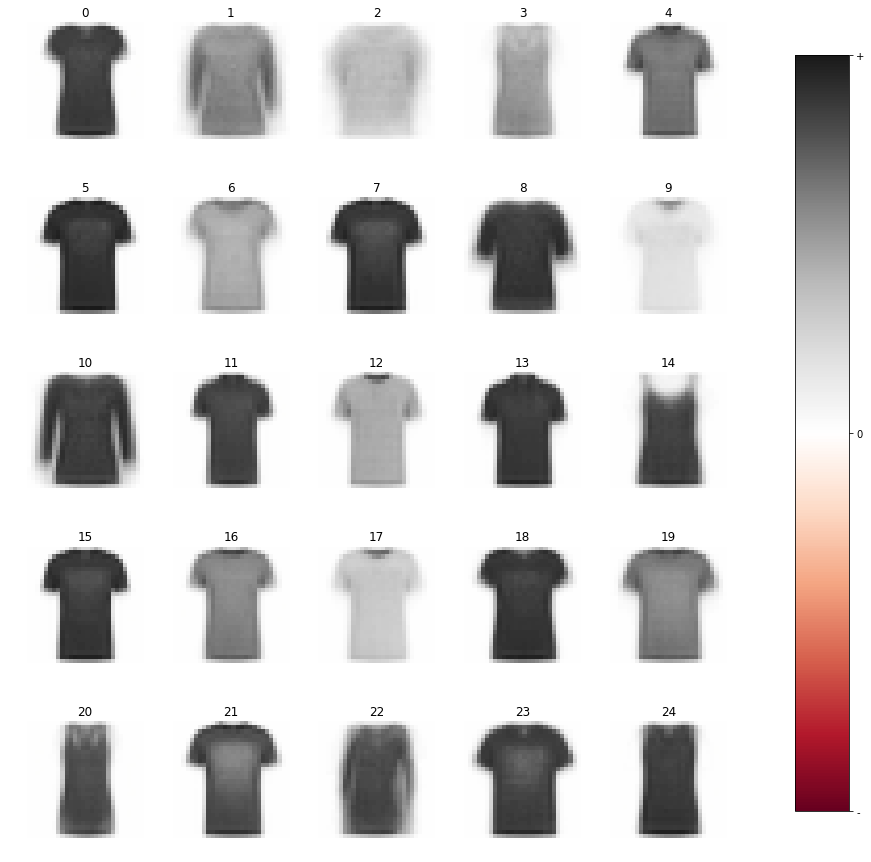

In [16]:
plot_codebook(kmeans)

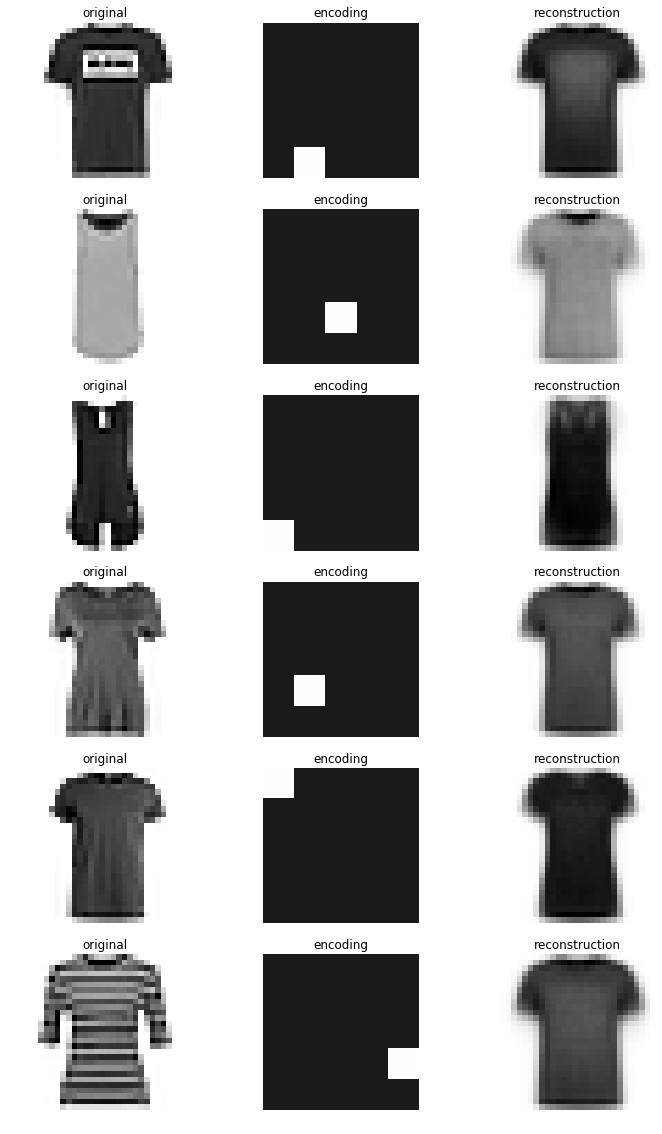

In [17]:
plot_encodings(Xc,kmeans)